In [1]:
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import tqdm
import sklearn
from sklearn import datasets
from sklearn import svm
from typing import Optional

# Linear Regression


*   Dataset: house price from boston
*   Objective: implement both numerical + analytical solutions
*   PLot and check for convergence
*   Compare with Linear Regression using sklearn


1.   Analytical solution: $\beta = (X^TX)^{-1}X^T y$
2.   Numerical solution:

      *   Loss function (MSE): $\mathcal{L} (y, \hat{y}) = \frac{1}{N}\sum_{i=1}^N (y-\hat{y})^2$
      *   Update rule: $\beta_{t+1} = \beta_t - \gamma \nabla \mathcal{L} (\beta_t)$
      *   Momentum: $\Delta \beta_{t+1} = -\gamma \nabla \mathcal{L}(\beta_{t+1}) + \alpha\Delta \beta_{t}$
      *   Update rule for momentum:  $\beta_{t+1} = \beta_t + \Delta \beta_{t}$









In [2]:
# LOAD DATA
X, y = datasets.load_boston(return_X_y=True)
X = np.hstack((
    np.ones(shape=(X.shape[0], 1)), X,
))
X.shape, y.shape

((506, 14), (506,))

In [3]:
def timer(f):
  def helper(*args, **kwargs):
    print(f"function: {f.__name__}")
    t1 = time.time()
    out = f(*args, **kwargs)
    t2 = time.time()
    print(f"elapsed time: {t2-t1}")
    return out
  return helper


In [4]:
# IMPLEMENT NUMERICAL SOLUTION HERE
@timer
def analytical_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  assert len(X.shape) == 2, "X must be a matrix"
  assert len(y.shape) == 1, "y must be a vector"
  assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
  beta = np.linalg.inv(X.T @ X) @ X.T @ y
  return beta

In [5]:
# IMPLEMENT GRADIENT DESCENT HERE
# REQUIREMENTS: a function to calculate the gradient , a function to calculate the loss function, a function to excecute gradient descent
class LinearRegression:
  def predict(self, X: np.ndarray) -> np.ndarray:
    assert len(X.shape) == 2, "X must be a matrix"
    assert X.shape[1] == self.num_features, "X.shape[1] must equal num_features"
    return X @ self.beta

  @staticmethod
  def cost_function(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert len(beta.shape) == 1, "beta must be a vector"
    assert X.shape[1] == beta.shape[0], "X.shape[1] must equal beta.shape[0]"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    y_ = X @ beta
    return np.mean((y_ - y)**2)

  @staticmethod
  def gradient(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert len(beta.shape) == 1, "beta must be a vector"
    assert X.shape[1] == beta.shape[0], "X.shape[1] must equal beta.shape[0]"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    y_ = X @ beta
    return 2 * np.mean((y_ - y).reshape(y.shape[0], 1) * X, axis=0)
        
  def fit(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float = 0.05):
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))

    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) >= tau:
        break
      # update parameter
      beta -= gamma * self.gradient(X, y, beta)
      # save progress
      loss.append(self.cost_function(X, y, beta))
      if np.isnan(loss[-1]).any():
        print(loss)
        raise Exception("NaN")
      if np.isinf(loss[-1]).any():
        print(loss)
        raise Exception("Inf")

    self.beta = beta
    self.loss = loss


  def fit_momentum(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float =0.05, alpha: float = 0.05, nesterov: bool=True):
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    beta_d = np.zeros_like(beta)
    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) < tau:
        break
      # update parameter
      if not nesterov:
        grad = self.gradient(X, y, beta)
      else:
        grad = self.gradient(X, y, beta + alpha * beta_d)
      beta_d = alpha * beta_d - gamma * grad
      beta += beta_d
      # save progress
      loss.append(self.cost_function(X, y, beta))
      if np.isnan(loss[-1]).any():
        print(loss)
        raise Exception("NaN")
      if np.isinf(loss[-1]).any():
        print(loss)
        raise Exception("Inf")
      
    self.beta = beta
    self.loss = loss

@timer
def gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  assert len(X.shape) == 2, "X must be a matrix"
  assert len(y.shape) == 1, "y must be a vector"
  assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
  model = LinearRegression()
  model.fit_momentum(X, y, gamma=0.000001, tau=0.00001, nesterov=True)
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(np.arange(1, 1+len(model.loss)), model.loss)
  ax.set_title("gradient descent")
  ax.set_xlabel("iteration")
  ax.set_ylabel("loss")
  return model.beta

In [6]:
# SOLUTION FROM SKLEARN
@timer
def sklearn_gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  assert len(X.shape) == 2, "X must be a matrix"
  assert len(y.shape) == 1, "y must be a vector"
  assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
  from sklearn.linear_model import LinearRegression
  model = LinearRegression()
  model.fit(X[:, 1:], y)
  beta = np.empty(shape=(X.shape[1], ))
  beta[0], beta[1:] = model.intercept_, model.coef_
  return beta

In [7]:
def mse(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> float:
  return float(np.mean((X @ beta - y)**2))

function: analytical_solution
elapsed time: 0.0003409385681152344
function: gradient_descent
elapsed time: 72.07220196723938
function: sklearn_gradient_descent
elapsed time: 0.0016129016876220703
21.8948311817292
28.112797412374807
21.894831181729202


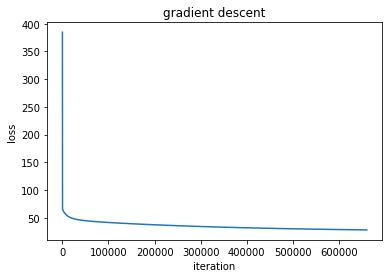

In [8]:
# VISUALIZATION
beta1 = analytical_solution(X, y)
beta2 = gradient_descent(X, y)
beta3 = sklearn_gradient_descent(X, y)
print(mse(X, y, beta1))
print(mse(X, y, beta2))
print(mse(X, y, beta3))

# Logistic Regression

*   Dataset: breast cancer dataset
*   Objective: implement both numerical solution
*   PLot and check for convergence
*   Compare with Linear Regression using sklearn


#   Numerical solution:

*   Loss function (Maximum Likelihood Estimator): $\mathcal{L} (y,\hat{y}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i\cdot\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\right]$
      

In [9]:
X,y = datasets.load_breast_cancer(return_X_y = True)
# Normalized X
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
np.mean(X, axis=0), np.std(X, axis=0)
# add one
X = np.hstack((
    np.ones(shape=(X.shape[0], 1)), X,
))
X.shape, y.shape

((569, 31), (569,))

In [10]:
class LogisticRegression:
  def predict(self, X: np.ndarray) -> np.ndarray:
    assert len(X.shape) == 2, "X must be a matrix"
    return LogisticRegression.logistic_function(X @ self.beta)

  @staticmethod
  def logistic_function(t: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-t))
    
  @staticmethod
  def cost_function(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    y_ = LogisticRegression.logistic_function(X @ beta)
    return - np.mean(y * np.log(y_) + (1-y) * np.log(1-y_))

  @staticmethod
  def gradient(X: np.ndarray, y: np.ndarray, beta: np.ndarray):
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert len(beta.shape) == 1, "beta must be a vector"
    assert X.shape[1] == beta.shape[0], "X.shape[1] must equal beta.shape[0]"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    y_ = X @ beta
    g =  np.mean((y_ - y).reshape(y.shape[0], 1) * X, axis=0)
    return g
    
  def fit(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float = 0.05):        
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    
    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) >= tau:
        break
      # update parameter
      beta -= gamma * self.gradient(X, y, beta)
      # save progress
      loss.append(self.cost_function(X, y, beta))
      if np.isnan(loss[-1]).any():
        print(loss)
        raise Exception("NaN")
      if np.isinf(loss[-1]).any():
        print(loss)
        raise Exception("Inf")

    self.beta = beta
    self.loss = loss

  def fit_momentum(self, X: np.ndarray, y: np.ndarray, tau: float = 0.01, gamma: float =0.05, alpha: float = 0.05, nesterov: bool=True):
    assert len(X.shape) == 2, "X must be a matrix"
    assert len(y.shape) == 1, "y must be a vector"
    assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
    loss = []
    beta = np.random.normal(loc=0, scale=1/X.shape[1], size=(X.shape[1], ))
    beta_d = np.zeros_like(beta)

    self.cost_function(X, y, beta)

    while True:
      if len(loss) >= 2 and abs(loss[-1] - loss[-2]) < tau:
        break
      # update parameter
      if not nesterov:
        grad = self.gradient(X, y, beta)
      else:
        grad = self.gradient(X, y, beta + alpha * beta_d)
      beta_d = alpha * beta_d - gamma * grad
      beta += beta_d
      # save progress
      loss.append(self.cost_function(X, y, beta))
      if np.isnan(loss[-1]).any():
        print(loss)
        raise Exception("NaN")
      if np.isinf(loss[-1]).any():
        print(loss)
        raise Exception("Inf")

    self.beta = beta
    self.loss = loss
@timer
def gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  assert len(X.shape) == 2, "X must be a matrix"
  assert len(y.shape) == 1, "y must be a vector"
  assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
  model = LogisticRegression()
  model.fit_momentum(X, y, gamma=0.000001, tau=0.0000001, nesterov=True)
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(np.arange(1, 1+len(model.loss)), model.loss)
  ax.set_title("gradient descent")
  ax.set_xlabel("iteration")
  ax.set_ylabel("loss")
  return model.beta

In [11]:
# SOLUTION FROM SKLEARN
@timer
def sklearn_gradient_descent(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  assert len(X.shape) == 2, "X must be a matrix"
  assert len(y.shape) == 1, "y must be a vector"
  assert X.shape[0] == y.shape[0], "X.shape[0] must equal y.shape[0]"
  from sklearn.linear_model import LogisticRegression
  model = LogisticRegression()
  model.fit(X[:, 1:], y)
  beta = np.empty(shape=(X.shape[1], ))
  beta[0], beta[1:] = model.intercept_, model.coef_
  return beta

In [12]:
def eval(X, y, beta):
  from sklearn.metrics import classification_report
  y_ = LogisticRegression.logistic_function(X @ beta) > 0.5
  print(classification_report(y, y_))

function: gradient_descent
elapsed time: 75.59607076644897
function: sklearn_gradient_descent
elapsed time: 0.01868581771850586
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       212
           1       0.91      0.99      0.95       357

    accuracy                           0.94       569
   macro avg       0.95      0.92      0.93       569
weighted avg       0.94      0.94      0.94       569

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       212
           1       0.99      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



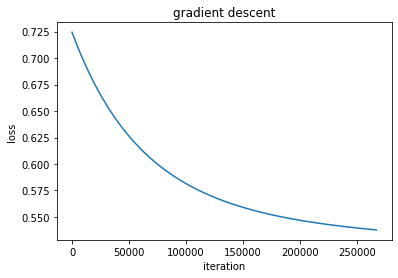

In [13]:
# VISUALIZATION
beta2 = gradient_descent(X, y)
beta3 = sklearn_gradient_descent(X, y)
eval(X, y, beta2)
eval(X, y, beta3)

# Support Vector Machine


*   Dataset: breast cancer
*   Objective: understand how SVM work/ the effects of choosing kernels on dataset



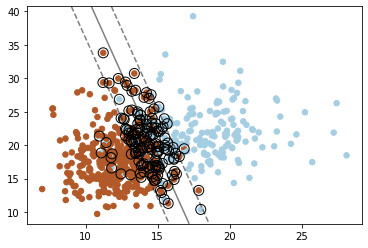

In [14]:
X, y = datasets.load_breast_cancer(return_X_y = True)
X = X[:,:2]

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()